In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb_model_1 import *

# Load SciPlex2 data from Lotfollahi et al 2023
Datasets are available form -> https://github.com/theislab/CPA

In [15]:
adata = sc.read('SciPlex2_new.h5ad')

torch.manual_seed(3141592)
# load data:
my_conditioner = pd.read_csv("SciPlex2_perturbation.csv", index_col=0)
my_conditioner = my_conditioner.drop('Vehicle', axis=1)  # TODO: or retaining it
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)
my_conditioner = torch.pow(my_conditioner, 0.2)  # a power transformation of dosages

my_observation = pd.read_csv("SciPlex2.csv", index_col=0)
print(my_observation.shape)
my_observation = torch.tensor(my_observation.to_numpy() * 1.0, dtype=torch.float)

gene_name = list(pd.read_csv('SciPlex2_gene_name.csv').to_numpy()[:, 0])

my_cell_info = pd.read_csv("SciPlex2_cell_info.csv", index_col=0)
my_cell_info.n_genes = my_cell_info.n_genes/my_cell_info.n_counts
my_cell_info.n_counts = np.log(my_cell_info.n_counts)
cell_info_names = list(my_cell_info.columns)
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)

C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


(20643, 5000)


# Specify and train Gaussian GPerturb

In [16]:
# design the training process:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 700  # or 1000
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 1e-3  
nu_1, nu_2, nu_3, nu_4, nu_5, nu_6 = torch.tensor([1., 1e-2, 1., 1e-2, 3., 1e-2]).to(device)
tau = torch.tensor(1.).to(device)

parametric_model = GPerturb_gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                               data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                               hidden_layer_2=hidden_layer, tau=tau)
parametric_model.test_id = testing_idx = list(np.random.choice(a=range(my_observation.shape[0]), size=my_observation.shape[0] // 8, replace=False))
parametric_model = parametric_model.to(device)

# train from scratch
# parametric_model.GPerturb_train(epoch=250, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 nu_1=nu_1, nu_2=nu_2, nu_3=nu_3, nu_4=nu_4, nu_5=nu_5, nu_6=nu_6, lr=lr_parametric, device=device)

# load from pre-computed
parametric_model.load_state_dict(torch.load('BSAPR_SciPlex2_Gaussian_3.pt'))
parametric_model=parametric_model.to('cpu')

# Fig 11

C:\Users\86304\AppData\Local\Temp\ipykernel_21088\4053451999.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_unique_pert[i] = estimated_total_mean[np.array(adata.obs.drug_dose_name[parametric_model.test_id] == name)].mean(axis=0)


4


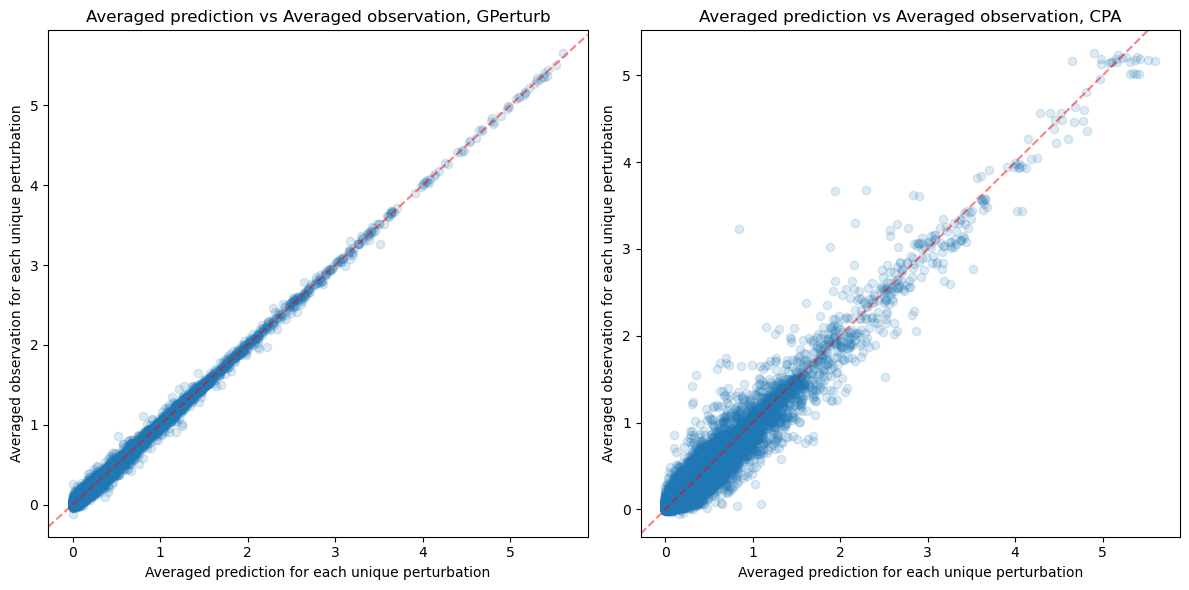

In [17]:
# compute from model
predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
    logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[parametric_model.test_id], my_cell_info[parametric_model.test_id])
estimated_base_mean = predicted_base_mean.detach().cpu().numpy()
estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
estimated_total_mean = (estimated_perturbed_mean + estimated_base_mean)
estimated_perturbed_var = logexpp1(parametric_model.base_log_var + (F.sigmoid(logit_p) * predicted_gamma_mean)).detach().cpu().numpy()


avg_unique_pert = np.zeros((len(adata.obs.drug_dose_name.unique()), output_dim))
avg_obs = np.zeros((len(adata.obs.drug_dose_name.unique()), output_dim))
unique_pert = np.array(adata.obs.drug_dose_name.unique())
baseline_id = 0
for i, name in enumerate(list(adata.obs.drug_dose_name.unique())):
    if name == 'Vehicle_1.0':
        baseline_id = i
        print(i)
    avg_unique_pert[i] = estimated_total_mean[np.array(adata.obs.drug_dose_name[parametric_model.test_id] == name)].mean(axis=0)
    avg_obs[i] = my_observation[np.array(adata.obs.drug_dose_name == name)].mean(axis=0).numpy()
avg_obs = np.delete(avg_obs, baseline_id, 0)
avg_unique_pert = np.delete(avg_unique_pert, baseline_id, 0)

# load pre-computed
# avg_obs = pd.read_csv('./GPerturb_vis_data/Sciplex2_Gaussian_obs.csv').to_numpy()
# avg_unique_pert = pd.read_csv('./GPerturb_vis_data/Sciplex2_Gaussian_est.csv').to_numpy()

fig, axs = plt.subplots(1, 2)

axs[0].scatter(avg_obs.ravel(), avg_unique_pert.ravel(), alpha=0.15)
axs[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axs[0].set_xlabel('Averaged prediction for each unique perturbation')
axs[0].set_ylabel('Averaged observation for each unique perturbation')
axs[0].set_title('Averaged prediction vs Averaged observation, GPerturb')


CPA_avg_pred = pd.read_csv('./GPerturb_vis_data/CPA_SciPlex2_avg_pred.csv', index_col=0).to_numpy().ravel()
axs[1].scatter(avg_obs.ravel(), CPA_avg_pred, alpha=0.15)
axs[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axs[1].set_xlabel('Averaged prediction for each unique perturbation')
axs[1].set_ylabel('Averaged observation for each unique perturbation')
axs[1].set_title('Averaged prediction vs Averaged observation, CPA')
fig.set_size_inches(12, 6)
fig.tight_layout()
# plt.savefig('./GPerturb_vis/GPerturb_vs_CPA_SciPlex2_3.png', dpi=300)

# Fig 12

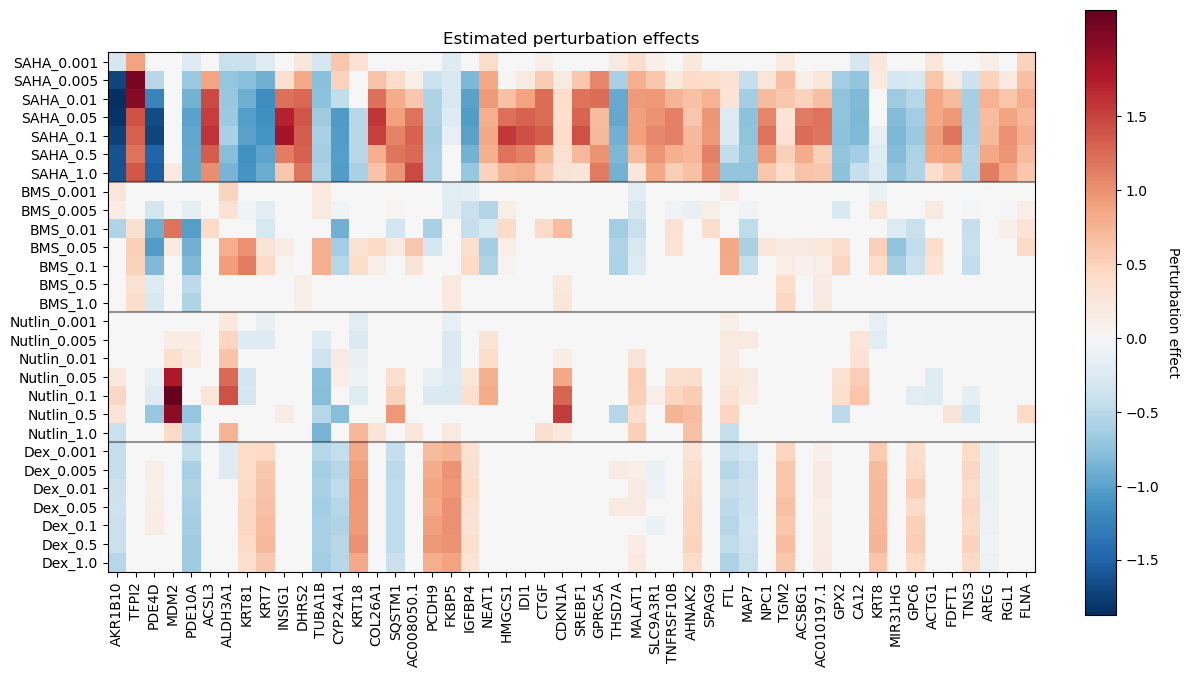

In [20]:
# compute from model
p = 0.95
top=50
# how does each condition affect different genes?
unique_conditions = torch.unique(my_conditioner, dim=0)
perturb_level, _, _, _, logit_p, _, _ = parametric_model(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > p
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]
top_id = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]
estimated_pert = estimated_pert[:, top_id]
my_gene_name = my_gene_name[top_id]

unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Vehicle_1.0'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] != 0.][0] + '_' + str(np.round((unique_conditions[i][unique_conditions[i] != 0][0])**5,3))

# load pre-trained
# estimated_pert = pd.read_csv('./GPerturb_vis_data/Sciplex2_pert_level.csv').to_numpy()
# my_gene_name = list(pd.read_csv('./GPerturb_vis_data/Sciplex2_my_gene_name.csv').to_numpy().ravel())
# my_yticks = list(pd.read_csv('./GPerturb_vis_data/Sciplex2_my_yticks.csv').to_numpy().ravel())

fig, ax1 = plt.subplots(1,1)

import matplotlib.colors as colors
negatives = estimated_pert.min()
positives = estimated_pert.max()

num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
[cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = ax1.imshow(estimated_pert[1:], cmap=cmap_2neg_4pos)
for i in [6.5, 13.5, 20.5]:
    ax1.axline((i, i), slope=0, alpha=0.4, c='k')
ax1.set_xticks(np.arange(len(my_gene_name)), my_gene_name, rotation=90)
ax1.set_yticks(np.arange(len(my_yticks)-1), my_yticks[1:])
ax1.set_title('Estimated perturbation effects')
ticks = np.append(np.arange(-2., 0., .5), np.arange(0, 2, 0.5))
cbar = fig.colorbar(im, ax=ax1, ticks=ticks, fraction=0.03)
cbar.ax.set_ylabel('Perturbation effect', rotation=270, labelpad=15)
fig.set_size_inches(12, 8)
fig.tight_layout()
# plt.savefig('./GPerturb_vis/GPerturb_heatmap_SciPlex2_3.png', dpi=300)

# Fig 13

0
1
2
3


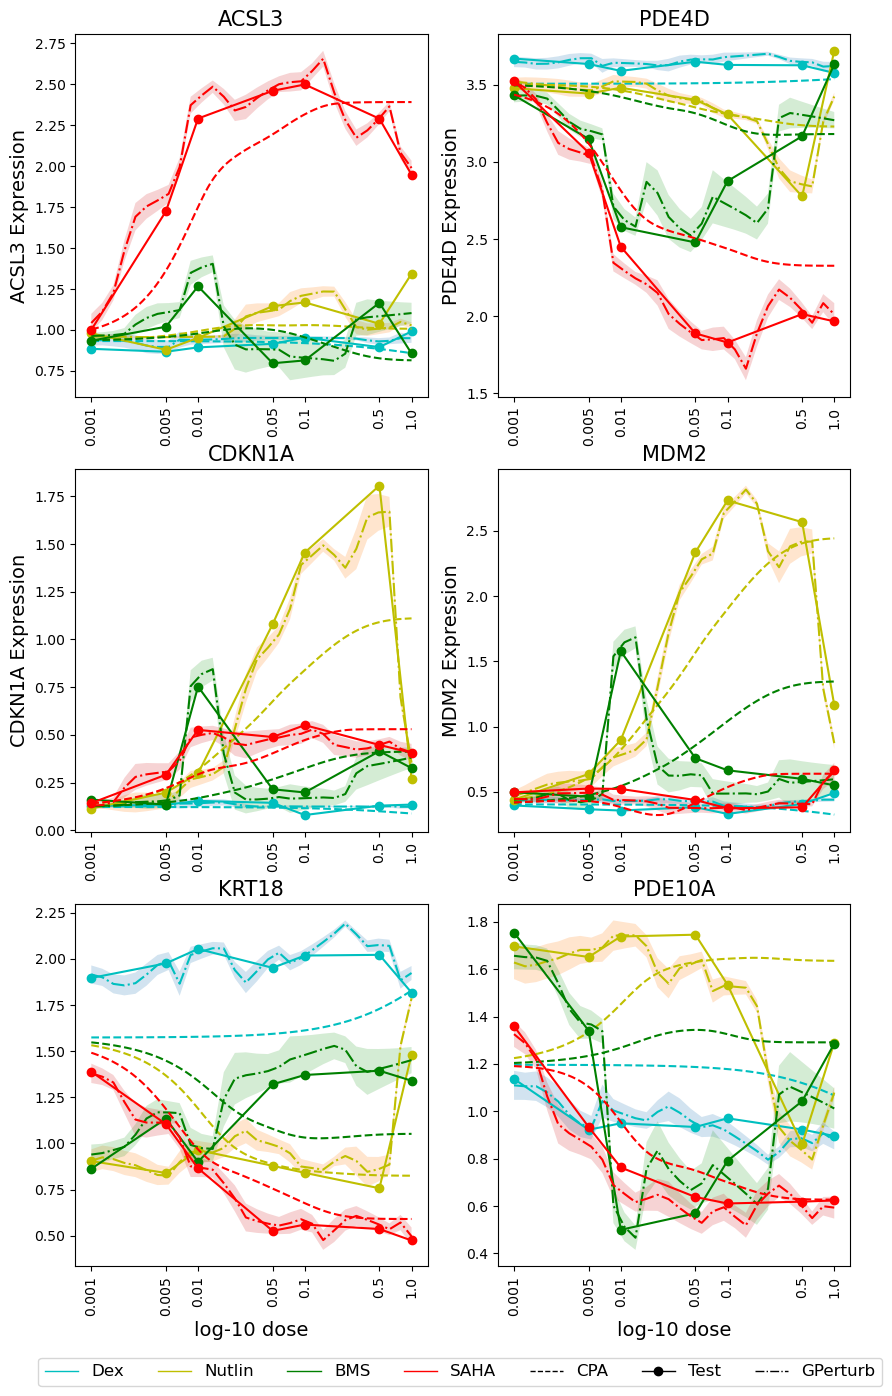

In [19]:
degs = ['ACSL3', 'PDE4D', 'CDKN1A','MDM2', 'KRT18', 'PDE10A']
# compute from model
perturb_level, _, _, _, logit_p, _, base_mean = parametric_model(my_conditioner, my_cell_info)
GPerturb_base = base_mean.detach().cpu().numpy().mean(0)
GPerturb_avg_pred = []
for i in range(4):
    print(i)
    uc = torch.zeros((30, 4))
    uc[:, i] = torch.pow(10**torch.linspace(-3, 0, 30), 0.2)
    perturb_level, pert_level_log_var, _, _, logit_p, _, _ = parametric_model(uc, None)
    pert_upper = perturb_level + 2*torch.exp(0.5 * pert_level_log_var)
    pert_lower = perturb_level - 2*torch.exp(0.5 * pert_level_log_var)
    pert_est = (perturb_level * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est_upper = (pert_upper * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est_lower = (pert_lower * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est = pert_est[:, [gene_name.index(i) for i in degs]]
    pert_est_upper = pert_est_upper[:, [gene_name.index(i) for i in degs]]
    pert_est_lower = pert_est_lower[:, [gene_name.index(i) for i in degs]]

    for k, j in enumerate(10**np.linspace(-3, 0, 30)):
        GPerturb_avg_pred.append(pd.DataFrame({'pert': [np.array(cond_name)[uc[0] != 0.][0]]*len(degs), 'dose': j,
                                            'gene': degs, 'BSAPR': pert_est[k], 'BSAPR_upper':pert_est_upper[k],
                                            'BSAPR_lower':pert_est_lower[k]}))
GPerturb_avg_pred = pd.concat(GPerturb_avg_pred)

# load from pre-computed
# GPerturb_avg_pred = pd.read_csv('./GPerturb_vis_data/Sciplex2_BSAPR_avg_pred.csv', index_col=0)


obs_avg = pd.read_csv('./GPerturb_vis_data/Sciplex2_obs_avg.csv', index_col=0)
CPA_avg_pred = pd.read_csv('./GPerturb_vis_data/Sciplex2_CPA_avg_pred.csv', index_col=0)

f, a = plt.subplots(nrows=3, ncols=2)
for i in range(6):
    my_data_CPA = CPA_avg_pred[CPA_avg_pred.gene==degs[i]]
    my_data_obs = obs_avg[obs_avg.gene == degs[i]]
    my_data_GPerturb = GPerturb_avg_pred[GPerturb_avg_pred.gene == degs[i]]
    lty = ['--', '-', '-.']
    col = ['c', 'y', 'g', 'r']
    for idx, j in enumerate(['Dex', 'Nutlin', 'BMS', 'SAHA']):
        a[i//2, i%2].plot(np.linspace(-3, 0, 100), np.array(my_data_CPA[my_data_CPA.pert == j].sort_values(by='dose').CPA), linestyle=lty[0], label=j, c=col[idx])
        a[i // 2, i % 2].plot(np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), np.array(my_data_obs[my_data_obs.pert == j].sort_values(by='dose').obs), linestyle=lty[1], marker='o', c=col[idx])
        a[i // 2, i % 2].plot(np.linspace(-3, 0, 30),
        np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR), linestyle=lty[2], c=col[idx])
        a[i // 2, i % 2].fill_between(np.linspace(-3, 0, 30),
        np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR_lower),
        np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR_upper), alpha=0.2)
        a[i // 2, i % 2].set_title(degs[i], fontdict = {'fontsize' : 15})
        a[i // 2, i % 2].set_xticks(ticks=np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), labels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], rotation=90)
    if i//2 == 2:
        a[i // 2, i % 2].set_xlabel('log-10 dose', fontdict = {'fontsize' : 14})
    else:
        a[i // 2, i % 2].set_xlabel('')
        a[i // 2, i % 2].set_ylabel(degs[i] + ' Expression', fontdict = {'fontsize' : 14})
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='c', lw=1, label='Dex'),
Line2D([0], [0], color='y', lw=1, label='Nutlin'),
Line2D([0], [0], color='g', lw=1, label='BMS'),
Line2D([0], [0], color='r', lw=1, label='SAHA'),
Line2D([0], [0], color='k', lw=1, linestyle='--', label='CPA'),
Line2D([0], [0], color='k', lw=1, linestyle='-', marker='o', label='Test'),
Line2D([0], [0], color='k', lw=1, linestyle='-.', label='GPerturb')]

f.legend(handles=legend_elements, loc='lower center', ncol=7, bbox_to_anchor=(.51, 0.03), prop={'size': 12})
f.set_size_inches(10, 16)
# plt.savefig('./GPerturb_vis/GPerturb_Sciplex2_curve.png', dpi=300)